# Hazard Assessment for Wildfire - Machine Learning Approach (CHELSA dataset)

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FIRE](https://github.com/CLIMAAX/FIRE) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

## Introduction

This Jupyter Notebook is used to compute a Hazard map for an area of interest using these inputs: DEM, Corine land-cover, Fire data, administrative level (NUTS).
Moreover, it is used to analyze fire hazard data and perform various preprocessing and analysis tasks.

The analysis is based on the hazard mapping works of [Tonini et al. 2020](https://doi.org/10.3390/geosciences10030105), [Trucchia et al. 2023](https://doi.org/10.1071/WF22138).

The workflow is based on the following steps:

- Data gathering and preprocessing.
- Building a model for wildfire susceptibility using present climate conditions and synoptic wildfire events. 
- Projecting the model to future climate conditions. 
- For both cases, susceptibility can be evolved to hazard by considering the different plant functional types, which are a proxy for the intensity of potential wildfires. See [Trucchia et al. 2023](https://doi.org/10.1071/WF22138) for more details. 
- Damage assessment for different vulnerability categories and exposed elements (roads) in order to get Risk maps.

Regarding climate, the [CHELSA](https://chelsa-climate.org/) dataset is used.


:::{seealso}

We also provide a version of this hazard assessment notebook based on the ECLIPS2.0 dataset: [Hazard assessment for Wildfire - ECLIPS dataset](Hazard_assessment_FIRE_ML.ipynb).
:::

## Preparation Work

The notebook is configured for the **Catalonia** region in Spain as a case study.
A prepared [sample dataset](https://handbook.climaax.eu/resources/datasets/wildfire_sample_cat.html) for Catalonia is available from the CLIMAAX cloud storage.

:::{admonition} Assessing risk for other regions
:class: important

To assess the wildfire hazard and risk for a **different region**, data equivalent to the provided Catalonia sample have to be provided and substituted throughout the workflow.
This includes:

- A shapefile of the region (sample data in `data_*/boundaries`)
- Digital Elevation Model (DEM) raster data (sample data for Spain in `data_*/dem2_3035.tif`)
- A dataset of historical fires (sample data in `data_*/fires`)
- Vulnerability data (sample data from [JRC](https://doi.org/10.2760/46951) with European coverage in `/data_cat/Vul_data/`; *risk assessment only*)
- Exposure data, e.g. for critical infrastructure (sample data in `data_cat/risk/`; *risk assessment only*)
- NUTS level data for aggregation (sample data for Spain in `data_cat/administrative_units_NUTS/`; *risk assessment only*)

Land cover data can be downloaded as part of this notebook (sample data from [CORINE](https://land.copernicus.eu/en/products/corine-land-cover) in `data/veg_corine_reclass.tif` also provided).
:::


Most of the analysis is based on raster calculations. The "base" raster is a clipped dem file (`data_cat/hazard/input_hazard/dem_3035_clip.tif`), which has been clipped using the extent of the Catalonia administrative shapefile. The raster is metric, using the EPSG:3035 projection, with 100 meter resolution, and with extent (left, bottom, right, top) given by:

    3488731.355 1986586.650 3769731.355 2241986.650

### Import libraries

:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

- [os](https://docs.python.org/3/library/os.html): Provides functions for interacting with the operating system, such as file operations and environment variables.
- [pooch](https://www.fatiando.org/pooch/latest/index.html): To download data from various sources (Zenodo, CLIMAAX cloud storage)
- [rasterio](https://rasterio.readthedocs.io/en/stable/): A library for reading and writing geospatial raster datasets. It provides functionalities to work with raster data formats such as GeoTIFF and perform various raster operations.
- [tqdm](https://github.com/tqdm/tqdm): A fast, extensible progress bar for Python and CLI. It allows for easy visualization of loop progress and estimates remaining time.
- [matplotlib.pyplot](https://matplotlib.org/): Matplotlib's plotting interface, providing functions for creating and customizing plots. %matplotlib inline is an IPython magic command to display Matplotlib plots inline within the Jupyter Notebook or IPython console.
- [numpy](https://numpy.org/): A fundamental package for scientific computing with Python. It provides support for large multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
- [gdal](https://gdal.org/): Python bindings for the Geospatial Data Abstraction Library (GDAL), used for reading and writing various raster geospatial data formats.
- [geopandas](https://geopandas.org/): Extends the Pandas library to support geometric operations on GeoDataFrames, allowing for easy manipulation and analysis of geospatial data.
- [pandas](https://pandas.pydata.org/): A powerful data manipulation and analysis library for Python. It provides data structures like DataFrame for tabular data and tools for reading and writing data from various file formats.
- [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html): Provides signal processing tools, including functions for filtering, spectral analysis, and convolution.
- [sklearn](https://scikit-learn.org/stable/): The scikit-learn library for machine learning in Python. It includes various algorithms for classification, regression, clustering, dimensionality reduction, and more. train_test_split is a function for splitting datasets into train and test sets, and RandomForestClassifier is an implementation of the Random Forest classifier algorithm.
:::

In [1]:
import os
import itertools
import pathlib
import urllib

import pooch
from tqdm import tqdm

from pyproj import Proj, transform, Transformer
from pyproj.transformer import TransformerGroup
from affine import Affine

import numpy as np
from osgeo import gdal, ogr
import geopandas as gpd
import pandas as pd
from scipy import signal
import rasterio
from rasterio import features
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.plot
from rasterio.mask import mask

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
import matplotlib.patches as mpatches

import xarray as xr

Import workflow-specific functions and classes shared between the ECLIPS and CHELSA notebooks from the `shared_funcs.py` file:

In [2]:
import shared_funcs

### Area name

Name for the area of interest (used for regional data folder and plot titles):

In [3]:
areaname = "Catalonia"

### Path configuration

Paths to data for the layers used in the notebook (mostly rasters and shapefiles).

In [4]:
data_path = pathlib.Path("./data")

# Digital elevation model [characteristics: tif - CRS[EPSG:3035], resolution 100m]
dem_path_full = data_path / "dem2_3035.tif"  # input (see below)

# CHELSA dataset folder
CHELSA_path = data_path / "CHELSA"
CHELSA_path_hist = CHELSA_path / "Historical"
CHELSA_path_future = CHELSA_path / "Future"

Region-specific files (input and output):

In [5]:
# Folder for regional input and output files
data_path_area = pathlib.Path(f"./data_{areaname}")

# Digital Elevation Model
dem_path = data_path_area / "dem"
dem_path.mkdir(parents=True, exist_ok=True)
dem_path_clip = dem_path / "dem_clip.tif"  # output or input (see below)
dem_path_slope = dem_path / "slope.tif"  # output
dem_path_aspect = dem_path / "aspect.tif"  # output
dem_path_easting = dem_path / "easting.tif"  # output
dem_path_northing = dem_path / "northing.tif"  # output
dem_path_roughness = dem_path / "roughness.tif"  # output

# Land cover/use dataset
clc_path = data_path_area / "land_cover_clc2018"
clc_path.mkdir(parents=True, exist_ok=True)
clc_path_clip = clc_path / "veg_corine_reclass_clip.tif"  # output
clc_path_clip_nb = clc_path / "veg_corine_reclass_clip_nb.tif"  # output, non-burnable

# Fires
fires_path = data_path_area / "fires"
fires_path.mkdir(parents=True, exist_ok=True)
fires_path_shapes = fires_path / "Forest_Fire_1986_2022_filtrat_3035.shp"  # input
fires_path_raster = fires_path / "fires_raster.tif"  # output

# Shapefile for area of interest
bounds_path = data_path_area / "boundaries"
bounds_path_area = bounds_path / f"{areaname}_adm_3035.shp"  # input

# Folder for CHELSA climate data (clipped, resampled, reprojected)
clim_path = data_path_area / "climate"
clim_path_hist = clim_path / "CHELSA_Historical"

# Output folder for hazard rasters
suscep_path = data_path_area / "susceptibility"
suscep_path.mkdir(parents=True, exist_ok=True)

# Output folder for hazard rasters
hazard_path = data_path_area / "hazard"
hazard_path.mkdir(parents=True, exist_ok=True)

### Download Catalonia sample data

To run the workflow for the Catalonia region, a [sample input dataset](https://handbook.climaax.eu/resources/datasets/wildfire_sample_cat.html) is downloaded from the CLIMAAX cloud storage.
We will download all files here before continuing.
A registry for the data that can be used by the pooch package is included with the workflow repository (`files_registry.txt`).
We load it here and retrieve all listed files.
If any files were downloaded before, pooch will inspect the local file contents and skip the download if the contents match expectations.

The data is downloaded into the folder `./data_Catalonia` (see variable `areaname`).

In [6]:
# Make sure that path configuration is appropriate for the example dataset
assert areaname == "Catalonia"

# Pooch downloader for workflow directory and CLIMAAX cloud storage
sample_pooch = pooch.create(
    path=".",
    base_url="https://object-store.os-api.cci1.ecmwf.int/climaax/wildfire_sample_cat/"
)
sample_pooch.load_registry("files_registry_cat.txt")

# Download all files from the attached registry
for path in sample_pooch.registry:
    if not path.startswith(str(clim_path)):
        sample_pooch.fetch(path)

## Region shapefile

Load a provided shapefile for the region of interest for clipping and plotting.

In [7]:
region_borders = gpd.read_file(bounds_path_area)

## Reference DEM

We use a Digital Elevation Model (DEM) of the area of interest as a reference for clipping other rasters.
The reference DEM is read as as a GeoTIFF with CRS[EPSG:3035].
The resolution of the DEM from the Catalonia example dataset is 100m.

### Clipping (if necessary)

The next cell can be used to extract the reference DEM from a larger DEM (`dem_path_full`) based on the provided shapefile of the area of interest (`bounds_path_area`).
If you are providing a reference DEM is directly (`dem_path_clip`), skip the next code cell.

In [8]:
# Clip raster with shapefile of area of interest
shapes = region_borders.geometry.values

# Clip the DEM file
with rasterio.open(dem_path_full) as src:
    out_image, out_transform = mask(src, shapes, crop=True)
    out_meta = src.meta.copy()

out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save the clipped raster
with rasterio.open(dem_path_clip, "w", **out_meta) as dest:
    dest.write(out_image)

Load the clipped DEM file as a reference for masking other raster data and extract bounds coordinates:

In [9]:
with rasterio.open(dem_path_clip) as src:
    ref = src.read(1)
    # Boundaries
    left = src.bounds.left
    bottom = src.bounds.bottom
    right = src.bounds.right
    top = src.bounds.top
    print(src.bounds)

BoundingBox(left=3488731.355109199, bottom=1986586.6503754416, right=3769731.355109199, top=2241986.6503754416)


### Obtain the slope and aspect layers

Process DEM: calculate slope, aspect and roughness and save them into the output folder.

Reading dem file data_Catalonia/dem/dem_clip.tif
This is what data_Catalonia/dem/dem_clip.tif looks like


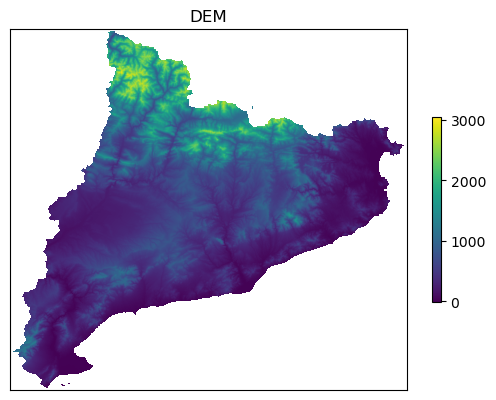

Calculating slope, aspect and roughness


/etc/ecmwf/ssd/ssd1/jupyterhub/ecm5975-jupyterhub/tmpdirs/ecm5975.43859087/conda/envs/climaax_hazard/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Calculating northing and easting files
Reading aspect file data_Catalonia/dem/aspect.tif
Aspect looks like this...


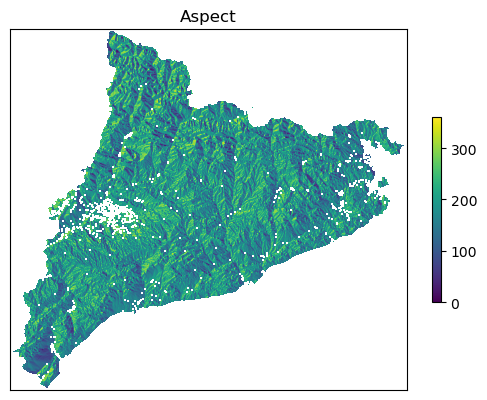

Saving northing file data_Catalonia/dem/northing.tif
Saving easting file data_Catalonia/dem/easting.tif


In [10]:
shared_funcs.process_dem(dem_path_clip, dem_path, verbose=True)

## CHELSA climate dataset

The [CHELSA](https://chelsa-climate.org/) (Climatologies at High resolution for the Earth’s Land Surface Areas) V2.1 dataset for the EUR-11 domain (Europe at 0.11° resolution, 
approximately 12.5 km) includes a variety of climate variables in annual and monthly resolutions.
CHELSA V2.1 is an updated, high-resolution climatology dataset that provides improved estimates for temperature, precipitation, and other climate-related variables.

### Data variables

We want the following set of variables:

| Variable Name                 | Code  | Description                                                  |
|-------------------------------|-------|--------------------------------------------------------------|
| Mean Annual Temperature       | bio1  | Average temperature over the year                            |
| Temperature Seasonality       | bio4  | Standard deviation of temperature over the year              |
| Annual Precipitation          | bio12 | Total precipitation accumulated over the year                |
| Precipitation Seasonality     | bio15 | Coefficient of variation for monthly precipitation           |                                                   
| Consecutive Dry Days          | cdd   | Number of consecutive days with no significant precipitation |
| Frost Days                    | fd    | Number of days with minimum temperature below 0°C            |
| Growing Degree Days Above 5°C | gdd5  | Sum of degrees above 5°C during the growing season           |

Names of the variables to download from CHELSA (different for each model and version):

In [11]:
var_names = ['bio01d', 'bio04d', 'bio12d', 'bio15d', 'cdd', 'fd', 'gdd5', 'prsd', 'scd', 'swe']

:::{admonition} Relative Humidity
:class: note dropdown

As you can see, there is no relative humidity (RH) in the dataset, ehen though RH is is important for Wildfire Risk Assessment.
RH is not calculated here, but we want to show the selected variables above can give a basic idea about RH to us.

Calculating relative humidity generally requires some key atmospheric variables, particularly temperature and dew point (or vapor pressure):

$$
\text{RH} = 100 \times \left( \frac{6.11 \times 10^{\left( \frac{7.5 \times T_d}{237.3 + T_d} \right)}}{6.11 \times 10^{\left( \frac{7.5 \times T}{237.3 + T} \right)}} \right),
$$

where

- $T$: air temperature (°C),
- $T_d$: dew point temperature (°C).

A rough estimate based on our available data could be:

$$
\text{RH} \approx 100 \times \left( \frac{T - \text{fd}}{T} \right),
$$

where

- $ T $: mean annual temperature (°C),
- $ T_d $: estimated dew point temperature derived from frost days.

In this approximation, the **Frost Days (fd)** are used to estimate the dew point temperature by subtracting the number of frost days from the mean annual temperature.
:::

### Select historical period for model training

Define historical period for model training by the start and end year (inclusive; data available from 1991 to 2020):

In [12]:
hist_start = 1991
hist_end = 2020

# List of all years in the historical period
hist_years = list(range(hist_start, hist_end+1))
hist_period = f"{hist_start}-{hist_end}"

:::{warning}

As of November 2024, there are no files for years 2019 and 2020 available for the variable `prsd`.
This data gap does not generally prevent the inclusion of years 2019 and 2020 in the historical period, because the historical data are averaged over the entire historical period after download.
The missing values do however result in a (slight) degradation of the representativity of the historical average for the variable `prsd`.
:::

### Download files for the historical period

In [13]:
CHELSA_urls_hist = [
    f"https://os.zhdk.cloud.switch.ch/chelsav2/EUR11/obs/annual/V2.1/{var_name}/CHELSA_EUR11_obs_{var_name}_{year}_V.2.1.nc"
    for year in hist_years
    for var_name in var_names
]

The number of files to download:

In [14]:
len(CHELSA_urls_hist)

300

We download each file and extract (clip) the data for our area of interest, writing GeoTIFFs.
The original files are removed after clipping to save disk space.

In [15]:
def download_data(url, out_dir, overwrite=False, verbose=False):
    # Create the output directory if it does not exist
    os.makedirs(out_dir, exist_ok=True)
    # Extract file name
    name_file = os.path.basename(url)
    path = os.path.join(out_dir, name_file)
    # Download
    if os.path.exists(path) and not overwrite:
        if verbose:
            print(f"{path} already exists. Skipping download.")
    else:
        if verbose:
            print(f"\nDownloading data from {url} to {path}")
        try:
            urllib.request.urlretrieve(url, path)
        except urllib.error.HTTPError as e:
            print(f"Download of {e.url} failed: {e.code} {e.reason}")
            return None
    return path


class CHELSAClipper:
    """Region extraction and GeoTIFF conversion for CHELSA data"""

    def __init__(self, left, right, top, bottom, crs="EPSG:3035"):
        # Transform the bounds of the reference DEM
        self.tg = TransformerGroup(crs, "EPSG:4326", always_xy=True)
        self.left, self.bottom = self.tg.transformers[0].transform(left, bottom)
        self.right, self.top = self.tg.transformers[0].transform(right, top)
        # Transform for writing the clipped CHELSA data in GeoTIFF format
        self.transform_clipped = Affine(
            float(0.0083333333),  # a
            float(0),  # b
            float(self.left),  # c (x-coordinate of the upper-left corner)
            float(0),  # d
            float(-0.0083333333),  # e
            float(self.top)  # f (y-coordinate of the upper-left corner)
        )

    def __call__(self, orig_path, out_dir):
        """Extract from orig_path and write a GeoTIFF in out_dir"""
        # Create the output directory if it does not exist
        os.makedirs(out_dir, exist_ok=True)
        # Open file and clip to bounds
        data_xr_ds = xr.open_dataset(orig_path)
        var_name = list(data_xr_ds.data_vars.keys())[-1]
        clipped_data = data_xr_ds.sel({
            "lon": slice(self.left-1, self.right+1),
            "lat": slice(self.bottom-1, self.top+1)
        })
        clipped_data = clipped_data[var_name]
        # Write as GeoTIFF
        name_file = os.path.join(out_dir, os.path.basename(orig_path))
        name_file = os.path.splitext(name_file)[0] + ".tif"
        clipped_data.rio.to_raster(name_file, transform=self.transform_clipped, nodata=-999)
        return name_file

In [16]:
# Initialize clipping function based on boundaries of reference DEM
get_clipped_raster = CHELSAClipper(left, right, top, bottom)

:::{caution}

One year of data for all variables is about 3 GB in size.
With up to 30 years covered by the CHELSA dataset for the historical period, the full dataset has a size of about 90 GB.
Depending on your selection for the historical period and internet connection, downloads may take a while.
:::

:::{tip}

To reduce the amount of required disk space, downloaded files are deleted immediately after clipping by default.
If you are interested in applying the workflow to multiple regions and have the disk space, you can omit the cleanup of downloaded files by commenting out the `os.remove(CHELSA_file)` in the next cell.
:::

In [17]:
# Download historical CHELSA data and clip to area of interest
for url in tqdm(CHELSA_urls_hist):
    CHELSA_file = download_data(url, CHELSA_path_hist)
    # None value returned on download error, skip further processing
    if CHELSA_file is not None:
        get_clipped_raster(CHELSA_file, clim_path_hist)
        # Delete the downloaded NetCDF file, only keep the clipped GeoTIFF
        os.remove(CHELSA_file)

 96%|█████████▌| 288/300 [01:53<00:03,  3.24it/s]

Download of https://os.zhdk.cloud.switch.ch/chelsav2/EUR11/obs/annual/V2.1/prsd/CHELSA_EUR11_obs_prsd_2019_V.2.1.nc failed: 404 Not Found


 99%|█████████▉| 298/300 [01:56<00:00,  3.38it/s]

Download of https://os.zhdk.cloud.switch.ch/chelsav2/EUR11/obs/annual/V2.1/prsd/CHELSA_EUR11_obs_prsd_2020_V.2.1.nc failed: 404 Not Found


100%|██████████| 300/300 [01:57<00:00,  2.55it/s]


:::{note}

More data for future scenarios are downloaded after the model training below.
:::

### Resample and reproject

Resample and reproject the CHELSA data to the same resolution and CRS as the DEM data.
The resampling method used is nearest interpolation.

In [18]:
def resample_clip_tif(files, left, bottom, right, top, ref_shape, remove_original=False):
    options = ["COMPRESS=LZW", "TILED=YES", "BIGTIFF=YES", "BLOCKXSIZE=512", "BLOCKYSIZE=512"]

    for path_tif in tqdm(list(files)):
        folder, name = os.path.split(path_tif)
        name = os.path.splitext(name)[0]

        # Reproject to EPSG:2035
        path_reprojected = os.path.join(folder, f"{name}_3035.tif")
        gdal.Warp(path_reprojected, path_tif, dstSRS="EPSG:3035", srcSRS="EPSG:4326", creationOptions=options)
        
        # Resample to 100m resolution to match reference DEM
        path_resampled = os.path.join(folder, f"{name}_3035_resampled.tif")
        gdal.Warp(path_resampled, path_reprojected, xRes=100, yRes=100, resampleAlg='bilinear', creationOptions=options)
        
        # Clip to area of interest
        path_clipped = os.path.join(folder, f"{name}_3035_clipped_resampled.tif")
        gdal.Warp(path_clipped, path_resampled, outputBounds=[left, bottom, right, top], creationOptions=options)
        
        # Verify that output matches reference DEM
        if rasterio.open(path_clipped).shape != ref_shape:
            print(f"Error in the shape of the raster {name}"
                "Go and change the initial bounds of the area of interest in the code (more extended)")
        # Clean-up
        else:
            if remove_original:
                os.remove(path_tif)
            os.remove(path_reprojected) 
            os.remove(path_resampled)

In [20]:
resample_clip_tif(
    clim_path_hist.glob("CHELSA_*_V.2.1.tif"),
    left, bottom, right, top,
    ref_shape=ref.shape,
    remove_original=False
)

100%|██████████| 298/298 [11:55<00:00,  2.40s/it]


### Averaging over historical period

Average the climatic data for the chosen historical period (directly write to file):

In [21]:
def average_var(list_var, output_path, dem_arr=ref, dem_path=dem_path_clip):
    # Open each raster, read the first band, and store the data in a list
    list_arr_data = [rasterio.open(path_mean).read(1) for path_mean in list_var if os.path.exists(path_mean)]
    # Ensure we have data to average
    if not list_arr_data:
        raise ValueError(f"No valid paths found to create {output_path}")
    # Convert to a numpy array and compute the mean along the stack
    arr_var = np.array(list_arr_data).mean(axis=0)
    arr_var[dem_arr == -9999] = -9999
    # Save the result using the specified function
    shared_funcs.save_raster_as(arr_var, output_path, dem_path)

In [22]:
for var_name in tqdm(var_names):
    # Collect paths for the current variable
    list_var = [clim_path_hist / f"CHELSA_EUR11_obs_{var_name}_{year}_V.2.1_3035_clipped_resampled.tif" for year in hist_years]
    # Load from all files and write averaged values to file
    average_var(list_var, clim_path_hist / f"CHELSA_EUR11_obs_{var_name}_mean_{hist_period}_V.2.1_3035_clipped_resampled.tif")

100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


## Landcover (land use raster)

**Dataset**: Corine landcover 2018 (CLC2018).

Provides pan-European CORINE Land Cover inventory for 44 thematic classes for the 2018 reference year. The dataset has a Minimum Mapping Unit (MMU) of 25 hectares (ha) for areal phenomena and a Minimum Mapping Width (MMW) of 100 m for linear phenomena and is available as vector and as 100 m raster data.

DOI (raster 100 m): [10.2909/960998c1-1870-4e82-8051-6485205ebbac](https://doi.org/10.2909/960998c1-1870-4e82-8051-6485205ebbac)

### Download and clip

Download and clip the CORINE raster to the extent of the area of interest based on the reference raster (DEM):

In [23]:
clc_path_full = pooch.retrieve(
    url="doi:10.5281/zenodo.13933243/U2018_CLC2018_V2020_20u1_3digits.tif",
    known_hash="a4557694d92d5a6a69021a42f3f93be54e0eade2b99543d18c4c9b84a8b442ee",
    fname="U2018_CLC2018_V2020_20u1_3digits.tif",
    path=data_path,
    progressbar=True
)

# Clipped land cover data [characteristics: tif - CRS[EPSG:3035], resolution 100m]
os.system(f"gdalwarp -t_srs EPSG:3035 -tr 100 -100 -te {left} {bottom} {right} {top} -r near  -overwrite -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=YES -co BLOCKXSIZE=512 -co BLOCKYSIZE=512 {clc_path_full} {clc_path_clip}")

Creating output file that is 2810P x 2554L.
Processing /lus/h2resw01/hpcperm/ecm5975/CLIMAAX/FIRE/01_wildfire_ML/data/U2018_CLC2018_V2020_20u1_3digits.tif [1/1] : 0Using internal nodata values (e.g. 128) for image /lus/h2resw01/hpcperm/ecm5975/CLIMAAX/FIRE/01_wildfire_ML/data/U2018_CLC2018_V2020_20u1_3digits.tif.
Copying nodata values from source /lus/h2resw01/hpcperm/ecm5975/CLIMAAX/FIRE/01_wildfire_ML/data/U2018_CLC2018_V2020_20u1_3digits.tif to destination data_Catalonia/land_cover_clc2018/veg_corine_reclass_clip.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


0

Optional: remove the downloaded original file to free disk space

In [24]:
os.remove(clc_path_full)

### Preprocessing

The shape(rows-columns) of LC map is:  (2554, 2810) 
 Datatype is:  float32 
 The range of values are:  0.0 523.0
Values of LC codes are:  
 [  0. 111. 112. 121. 122. 123. 124. 128. 131. 132. 133. 141. 142. 211.
 212. 213. 221. 222. 223. 231. 241. 242. 243. 311. 312. 313. 321. 322.
 323. 324. 331. 332. 333. 334. 335. 411. 421. 422. 511. 512. 521. 523.]


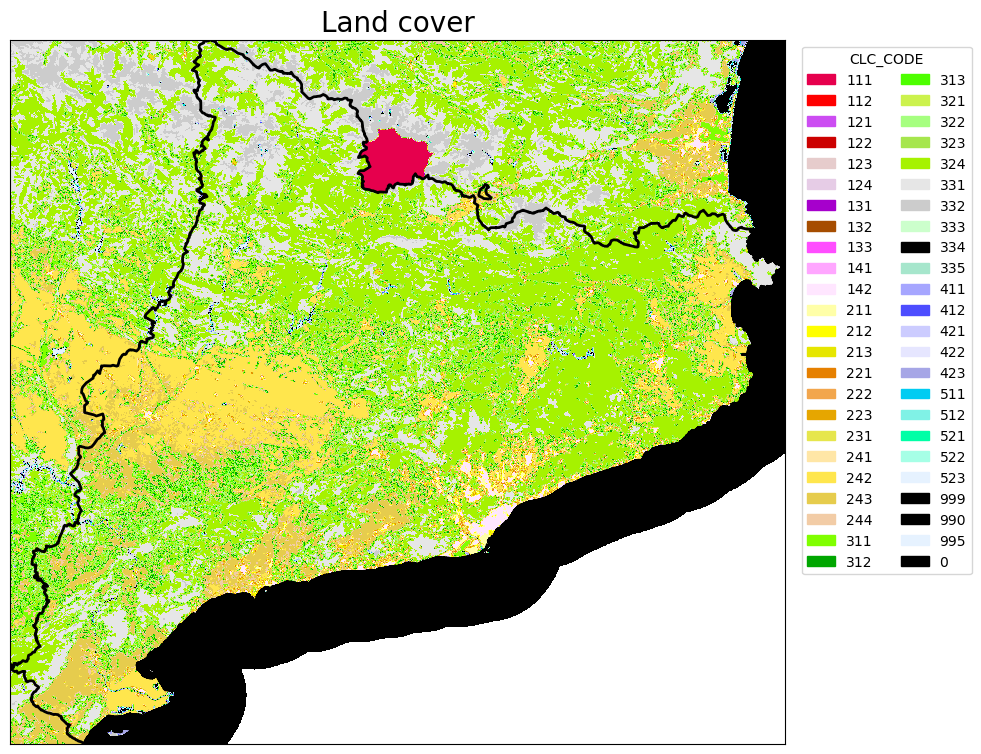

In [25]:
# Create an info dataframe on CLC land cover
clc_leg = pd.read_excel("clc2000legend.xls")

# Eliminate nans of the dataframe in column CLC_CODE, wioll put "0-0-0"
clc_leg["RGB"] = clc_leg["RGB"].fillna("0-0-0")

# Create dataframe with CLC_CODE, R, G, B (using split of RGB of clc_leg)
clc_leg["R"] = clc_leg["RGB"].apply(lambda x: int(x.split("-")[0]))
clc_leg["G"] = clc_leg["RGB"].apply(lambda x: int(x.split("-")[1]))
clc_leg["B"] = clc_leg["RGB"].apply(lambda x: int(x.split("-")[2]))

# I need to create a row for accouting for 0 values in the raster
_zero_values_row = pd.DataFrame({"CLC_CODE": 0, "LABEL3": "No data/Not Burnable", "R": 0, "G": 0, "B": 0}, index=[0])
clc_leg = pd.concat([clc_leg, _zero_values_row]).reset_index(drop=True)

# Create a colormap from the DataFrame
# For all clc codes
cmap = mcolors.ListedColormap(clc_leg[['R', 'G', 'B']].values/255.0, N=clc_leg['CLC_CODE'].nunique())
# For all clc codes except not burnable codes
cmap2 = mcolors.ListedColormap(clc_leg[['R', 'G', 'B']].values/255.0, N=clc_leg['CLC_CODE'].nunique() - 1)

# Create a list to hold the legend elements
legend_elements = []
# Iterate over the rows of the DataFrame
for _, row in clc_leg.iterrows():
    # Create a patch for each CLC code with the corresponding color and label
    color = (row['R']/255.0, row['G']/255.0, row['B']/255.0)
    #print(color)
    label = str(row['CLC_CODE'])
    #print(label)
    patch = mpatches.Patch(color=color, label=label)
    #print(patch)
    # Add the patch to the legend elements list
    legend_elements.append(patch)

# PLOT THE LAND COVER RASTER

# Open the raster data
with rasterio.open(clc_path_clip) as src:
    # Read the raster band
    band = src.read(1)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Plot the raster
    rasterio.plot.show(src, ax=ax, cmap = cmap)
    # Plot the shapefile
    region_borders.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)
    # band is the raster data.  I want to know nrows, ncols, NODATA_value, dtype.
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.25, 1), title="CLC_CODE", ncols=2)
    ax.set_title("Land cover", fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    print('The shape(rows-columns) of LC map is: ', band.shape,'\n','Datatype is: ', band.dtype,'\n', 'The range of values are: ' , band.min(),band.max())
    print('Values of LC codes are: ', '\n', np.unique(band))

Save the raster of clc with all non-burnable classes set to 0:

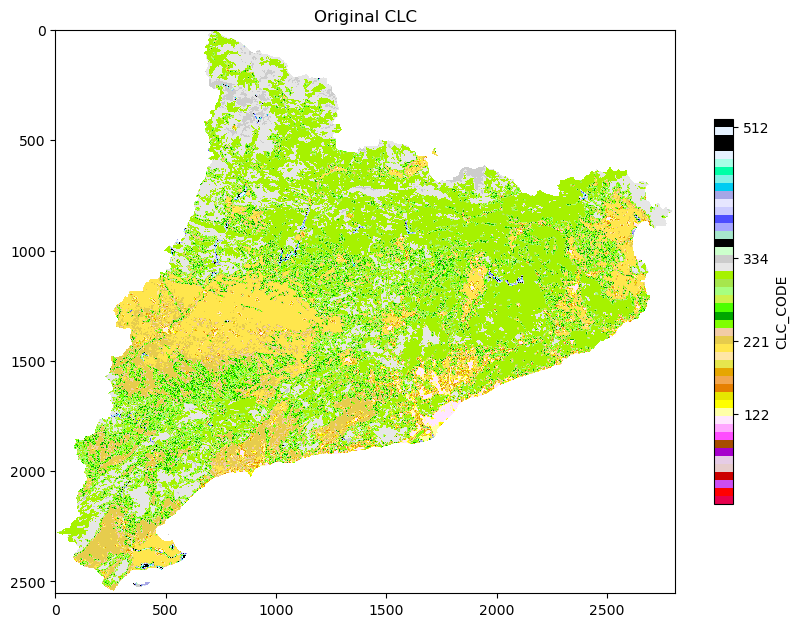

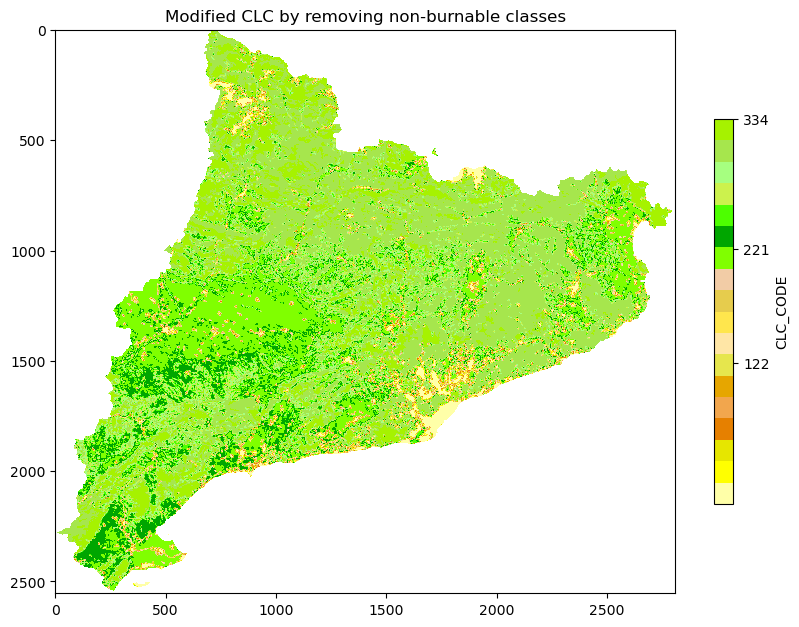

In [26]:
list_of_non_burnable_clc = [
    111, 112, 121, 122, 123, 124, 131, 132, 133, 141, 142,
    331, 332, 333, 335,
    411, 412, 421, 422, 423,
    511, 512, 521, 522, 523,
    999, 990, 995, 0
]

# Below, some considerations in the 3XX classes of the CLC and their degree of burnability.
# 331 332 333  are respectively beaches, dunes, sands; bare rocks; sparsely vegetated areas; in this case I will consider them as non-burnable
# 334 burnt areas in this case I will consider them as burnable
# 335 glaciers and perpetual snow in this case I will consider them as non-burnable

# Creating legends for newclc
burnables = set(clc_leg['CLC_CODE'].tolist()) - set(list_of_non_burnable_clc)
burnables = list(burnables)
cmap2_gdf = clc_leg.loc[:,['CLC_CODE','R', 'G', 'B']]
cmap2_gdf = cmap2_gdf[cmap2_gdf['CLC_CODE'].isin(burnables)]
cmap2 = mcolors.ListedColormap(cmap2_gdf[['R', 'G', 'B']].values/255.0, N=cmap2_gdf['CLC_CODE'].nunique()-1)

# Open the raster
with rasterio.open(clc_path_clip) as src:
    # Read the raster band
    band = src.read(1)
    # First plot, left side of the multiplot
    fig, ax = plt.subplots(figsize=(10, 10))
    # Plot the raster
    plt.imshow(np.where(ref == -9999, np.nan, band), cmap = cmap)
    plt.title('Original CLC')
    plt.colorbar(shrink = 0.5, label = 'CLC_CODE', ticks = [122, 221, 334, 512])
    plt.show()
    # Set the values in list_of_non_burnable_clc to 0
    band[np.isin(band, list_of_non_burnable_clc)] = 0
    # Plot the raster, right side of the multiplot
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(np.where(ref == -9999, np.nan, band), cmap = cmap2)
    plt.title('Modified CLC by removing non-burnable classes')
    plt.colorbar(shrink = 0.5, label = 'CLC_CODE', ticks = [122, 221, 334, 512])
    plt.show()
    # Save the modified raster
    with rasterio.open(clc_path_clip_nb, 'w', **src.profile) as dst:
        dst.write(band, 1)

## Fire Data

### Cleaning

Data cleaning of Catalan wildfires. Discard all rows whose `"YEAR_FIRE"` is not of 4 characters. How many are the rows discarded? The row discarded seem to be the overlapping fires... for this they have multiple date entries.

In [27]:
fires = gpd.read_file(fires_path_shapes)
print("Number of rows...", len(fires))

rows_discarded = len(fires) - len(fires[fires['YEAR_FIRE'].str.len() == 4])
fires_2 = fires[fires['YEAR_FIRE'].str.len() == 4]
fires_0 = fires[fires['YEAR_FIRE'].str.len() != 4]
print("Number of rows discarded:", rows_discarded)
print("These are the buggy entries in the FIRE_YEAR column...",fires_0.YEAR_FIRE.unique())
print("......")
print("I will convert to int the YEAR_FIRE column of the non buggy data...")

#fires_2.loc['YEAR_FIRE'] = fires_2['YEAR_FIRE'].astype(int)
fires_2.loc[:, 'YEAR_FIRE'] = fires_2['YEAR_FIRE'].astype(int) # to avoid setting with copy warning
print("The filtered dataset comprises of ", len(fires_2), "rows, spanning the years" , fires_2.YEAR_FIRE.min(), "to", fires_2.YEAR_FIRE.max())

# in the following, fires_2 will be our geo dataframe with the fires.
# Now selecting just the fires_2 with year > 1990
fires_2 = fires_2[fires_2['YEAR_FIRE'] > 1990]
print("After the filtering the final filtered dataset comprises of ", len(fires_2), "rows, spanning the years" , fires_2.YEAR_FIRE.min(), "to", fires_2.YEAR_FIRE.max())

Number of rows... 1217
Number of rows discarded: 395
These are the buggy entries in the FIRE_YEAR column... ['Unknown' '1995 - 2015 - 2012' '1995 - 2015 - 2021' '1995 - 2012 - 2021'
 '1995 - 2006 - 2010' '1995 - 1999 - 2002' '1995 - 2000 - 2021'
 '1986 - 1995 - 2019' '1986 - 1998 - 2004' '1988 - 1993 - 2001'
 '1986 - 2011' '1986 - 2012' '1986 - 1997' '1986 - 1995' '1998 - 2020'
 '1986 - 1999 - 2012' '1986 - 2003 - 2012' '1986 - 2004 - 2012'
 '1986 - 2006 - 2012' '1986 - 2007 - 2012' '1989 - 1994' '1989 - 2003'
 '1989 - 2005' '1989 - 2020' '1989 - 2014' '1989 -2012' '1990 - 1994'
 '1995 - 2010' '1995 - 2017' '1986 - 2000 - 2021' '1986 - 2001 - 2003'
 '1986 - 2001 - 2022' '1986 - 2002 - 2022' '1988 - 2001' '1988 - 2003'
 '1988 - 2009' '1988 - 2012' '1988 - 1991' '1988 - 1994' '1988 - 2007'
 '1986 - 2016' '1986 - 2022' '1986 - 1994' '1986 - 2005' '1994 - 2003'
 '1994 - 2011' '1994 - 1987' '1990 - 2016' '1990 - 2020' '2005 - 2020'
 '2005 - 2013' '2006 - 2012' '1986 - 2004 - 2022' '1986 - 1

To avoid overfitting I am going to delete two big fires from the data set. They are located in the central part of Catalonia and they did not represent the classical fire regime in the region.
198969,0
199033,0

In [28]:
fires_2 = fires_2.loc[(fires_2['OBJECTID'] != 199033.0) & (fires_2['OBJECTID'] != 198969.0),:]

The geodataframe of the fires is rasterized and saved to file(raster), using the corine land cover raster as a reference.

In [29]:
# Rasterize the fires...
fires_rasterized = shared_funcs.rasterize_numerical_feature(fires_2, clc_path_clip, column=None)
# save to file
shared_funcs.save_raster_as(fires_rasterized, fires_path_raster, clc_path_clip)

Shape of the reference raster: (2554, 2810)
Transform of the reference raster: | 100.00, 0.00, 3488731.36|
| 0.00,-100.00, 2241986.65|
| 0.00, 0.00, 1.00|
Features.rasterize is launched...
Features.rasterize is done...


### Visualization

Check that the rasterized fires can assume just the values 0 and 1 and there are no nan values.

The values of fire rasterised file are:  [0. 1.]
There is a NaN in file:  False


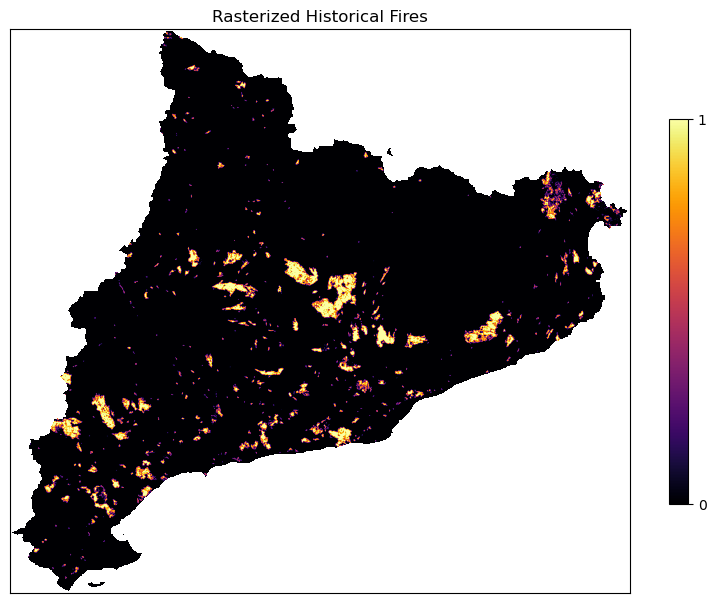

In [30]:
# Values of the rasterized fires
print('The values of fire rasterised file are: ', np.unique(fires_rasterized))

# Does the rasterized files have nan?
print('There is a NaN in file: ', np.isnan(fires_rasterized).any())

# Visualize the rasterized fires
fig, ax = plt.subplots(figsize=(10, 10))
cx = ax.imshow(np.where(ref == -9999, np.nan, fires_rasterized), cmap = 'inferno')
fig.colorbar(cx, ax=ax, shrink=0.5, ticks=[0, 1])
ax.set_title('Rasterized Historical Fires')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Creating our model

### Preparation

The `MyRaster` class is defined in `shared_funcs.py` to handle the path and metadata of a raster.
Additional functions assemble the dictionaries with the rasters to be used in the model.

In [31]:
def assemble_climate_dict(climate_folder_path, year_str, verbose=False):
    """
    Collect climate data from prepared CHELSA files.
    
    Parameters
    ----------
    climate_folder_path: path to the folder with the climatic data
    years: list with the years of the climatic data that will be used in the model
    """
    climate_dict = {}
    dir_names = os.listdir(climate_folder_path)
    # Sort so all output dicts have same variable order
    for name in sorted(dir_names):
        if year_str in name:
            path = os.path.join(climate_folder_path, name)
            label = name.split('_')[3]
            if verbose:
                print('FIND', path)
            climate_dict[label] = shared_funcs.MyRaster(path, label)
            climate_dict[label].read_raster()
    return climate_dict


def get_results(model, X_all, full_shape, mask):
    """Get the results of the model and returns a raster with the results
    
    Input:
    model: the model to fit
    X_all: the dataset with the descriptive features
    dem_arr: the dem array data
    mask: the mask of the dem array with all the valid and burnable pixels
    
    example usage:
    Y_raster = get_results( model, X_all,dem_arr, mask)
    """
    # prediction over all the points
    Y_out = model.predict_proba(X_all)
    # array of predictions over the valid pixels
    Y_raster = np.zeros(full_shape)
    Y_raster[mask] = Y_out[:,1]
    # clip susc where dem exsits
    Y_raster[~mask] = -1
    Y_raster[Y_raster<0] = 0
    return Y_raster

### Training the model

In [32]:
def make_model(res_path, period, verbose=False):
    # Climate model input fields
    climate_dict = assemble_climate_dict(res_path, period, verbose=verbose)
    # DEM input fields
    dem_dict = shared_funcs.assemble_dem_dict(
        [dem_path_clip, dem_path_slope, dem_path_aspect, dem_path_easting, dem_path_northing, dem_path_roughness],
        ["dem", "slope", "aspect", "easting", "northing", "roughness"]
    )
    # Vegetation input fields
    veg_dict, mask = shared_funcs.assemble_veg_dictionary(clc_path_clip_nb, dem_path_clip, verbose=verbose)
    # Fire data
    fires_raster = shared_funcs.MyRaster(fires_path_raster, "fires")
    # Preprocess and assemble training dataset
    X_all, Y_all, columns = shared_funcs.preprocessing(dem_dict, veg_dict, climate_dict, fires_raster, mask, verbose=verbose)
    # Prepare for model training
    model, X_train, X_test, y_train, y_test = shared_funcs.prepare_sample(X_all, Y_all, percentage=0.1, max_depth=8, number_of_trees=50)
    # Train the model
    shared_funcs.fit_and_print_stats(model, X_train, y_train, X_test, y_test, columns)
    # Return the trained model
    return model, list(columns)

In [33]:
model, columns = make_model(clim_path_hist, hist_period, verbose=False)

processing vegetation density: 100%|██████████| 18/18 [00:12<00:00,  1.50it/s]
processing columns: 35it [00:02, 16.76it/s]


Number of burned points: 149913
 I am random sampling the dataset 
reducted df points: 14991 of 149913
X_absence.shape[0] 5616602
X_presence.shape[0] 14991
Running RF on data sample: (20087, 35)
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building 

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.0s


building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


AUC score on train: 0.95
AUC score on test: 0.94
MSE: 0.09
accuracy: 0.87
I am evaluating features importance
importances
bio15d : 0.13
cdd : 0.13
perc : 0.11
bio01d : 0.09
swe : 0.07
fd : 0.06
veg : 0.06
slope : 0.06
gdd5 : 0.05
dem : 0.05
bio12d : 0.04
northing : 0.03
scd : 0.03
bio04d : 0.03
roughness : 0.02
prsd : 0.02
easting : 0.01
aspect : 0.0


### Visualizing feature importance

In [34]:
def plot_feature_importance(model, feature_names, figsize:tuple=(8, 8), len_feature:int=8):
    '''Take a trained model and the data dictionary and plot the feature importance'''
    # get the feature importance
    feature_importance = model.feature_importances_
    dict_importances = dict(zip(feature_names, feature_importance))
    
    # let us sum all percentages of neighbouring vegetation
    perc_keys = [k for k in feature_names if 'perc_' in k]
    perc_values = [dict_importances[k] for k in perc_keys]
    dict_importances['Total_neighboring'] = np.sum(perc_values)
    dict_importances = dict(sorted(dict_importances.items(), key=lambda item: item[1], reverse=True))
    feature_names = list(dict_importances.keys())[:len_feature]
    feature_importance = list(dict_importances.values())[:len_feature]
    
    # plot the feature importance
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=feature_importance, y=feature_names, ax=ax)
    ax.set_title('Feature Importance', fontsize="xx-large", color='black', fontweight='bold')
    #plt.savefig(save_path)
    plt.show()
    
    # do a spider plot also for the first len_feature features
    num_categories = len(feature_names)
    angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
    
    # Make the plot close
    feature_importance += feature_importance[:1]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True) )
    ax.fill(angles, feature_importance, color='skyblue', alpha=0.6, linewidth=2)
    ax.plot(angles, feature_importance, color='blue', linewidth=2)
    ax.set_yticks([0.1, 0.15], minor=True)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_names, fontsize=12, color='black', fontweight='bold', rotation=45, ha='left', wrap=True)
    fig.suptitle('Feature Importance', fontsize="xx-large", color='black', fontweight='bold')
    plt.tight_layout()
    plt.show()

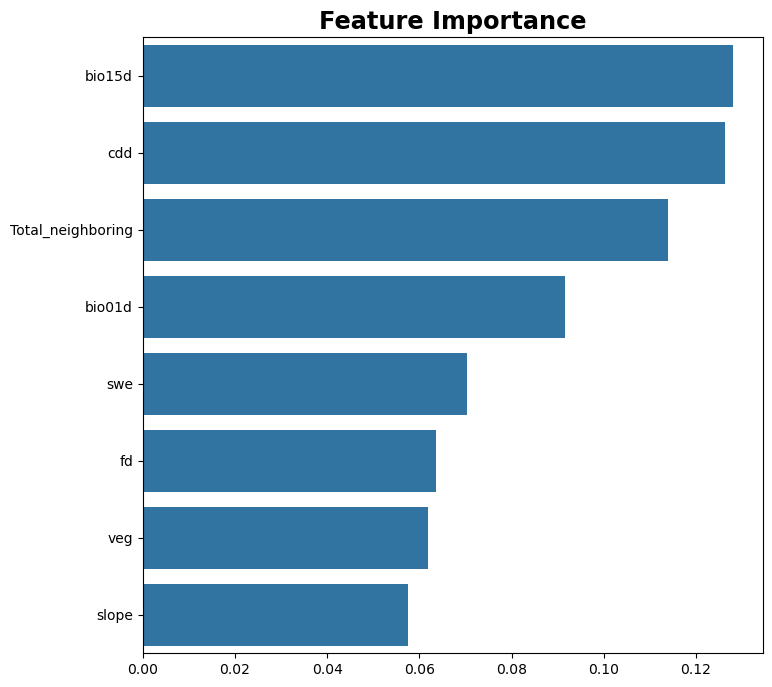

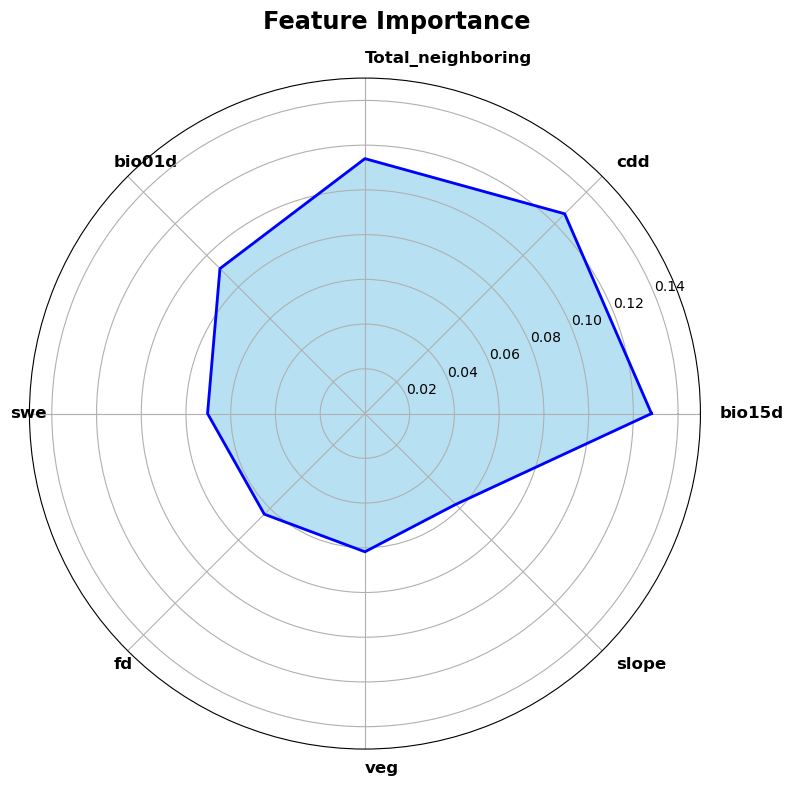

In [35]:
# Model performances
plot_feature_importance(model, columns, len_feature=8)

## Historical climate data

### Running the model for the historical climate

Apply the model to the historical (training) data and compute susceptibility.

In [36]:
def run_model(model, res_path, period, verbose=False):
    # Climate model input fields
    climate_dict = assemble_climate_dict(res_path, period, verbose=verbose)
    # DEM input fields (same as training)
    dem_dict = shared_funcs.assemble_dem_dict(
        [dem_path_clip, dem_path_slope, dem_path_aspect, dem_path_easting, dem_path_northing, dem_path_roughness],
        ["dem", "slope", "aspect", "easting", "northing", "roughness"]
    )
    # Vegetation input fields (same as training)
    veg_dict, mask = shared_funcs.assemble_veg_dictionary(clc_path_clip_nb, dem_path_clip, verbose=verbose)
    # Fire data not needed for running the model, but define output shape
    fires_raster = shared_funcs.MyRaster(fires_path_raster, "fires")
    # Preprocess and assemble input data for the ML model
    X_all, _, _ = shared_funcs.preprocessing(dem_dict, veg_dict, climate_dict, fires_raster, mask, verbose=verbose)
    # Evaluate the model and return results
    return get_results(model, X_all, fires_raster.data.shape, mask)

In [37]:
Y_raster = run_model(model, clim_path_hist, hist_period)

processing vegetation density: 100%|██████████| 18/18 [00:11<00:00,  1.51it/s]
processing columns: 35it [00:02, 16.54it/s]
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.4s


Convert results array to a raster and save to a file:

In [38]:
suscep_path_hist = suscep_path / f"suscep_HIST_{hist_period}.tif"

shared_funcs.save_raster_as(Y_raster, suscep_path_hist, dem_path_clip, nodata=np.nan)

I want to extract the 50, 75, 90, 95 quantiles of `Y_raster[Y_raster>=0.0]`. Since the susceptibility is the output of a random forest classifier with `proba = True`, its outputs are distributed between 0 and 1. I need to extract the quantiles of the positive values only, in order to get meaningful data from the arbitrary decisions of the classifier.

In [39]:
print(
    'Min susc is: ', Y_raster[Y_raster>=0.0].min(), '\n'
    'Max susc is: ', Y_raster[Y_raster>=0.0].max(), '\n'
    'Mean susc is: ', Y_raster[Y_raster>=0.0].mean(), '\n'
    'Standard deviation is:', Y_raster[Y_raster>=0.0].std(), '\n\n'
    'q1:', np.quantile(Y_raster[Y_raster>=0.0], 0.5), '\n'
    'q2:', np.quantile(Y_raster[Y_raster>=0.0], 0.75), '\n'
    'q3:', np.quantile(Y_raster[Y_raster>=0.0], 0.9), '\n'
    'q4:', np.quantile(Y_raster[Y_raster>=0.0], 0.95)
)

Min susc is:  0.0 
Max susc is:  0.9465089217659362 
Mean susc is:  0.1798748670428535 
Standard deviation is: 0.2687628050291007 

q1: 0.008282144775293937 
q2: 0.30701372930234394 
q3: 0.6354991189190455 
q4: 0.7752543407834732


### Susceptibility adjustment

TODO

In [50]:
def postprocess_susceptibility(band_, dem_arr=ref):
    # Here I will do a mask to remove the values of the susceptibility that are noisy
    # band = np.where(band_>0.65, 0.65, band_)
    band = np.where(band_ < 0.08, 0, band_)

    if np.max(band) > 0.80:
        band = np.where(band > 0.60, 0.75 * band, band)
    
    print(np.unique(band))
    print(np.mean(band))

    band = np.where(dem_arr == -9999, np.nan, band)
    return band

### Visualizing the historical susceptibility

Plot the susceptibility for the present climate:

[0.         0.08000013 0.08000027 ... 0.7049764  0.70509857 0.705264  ]
0.1497105


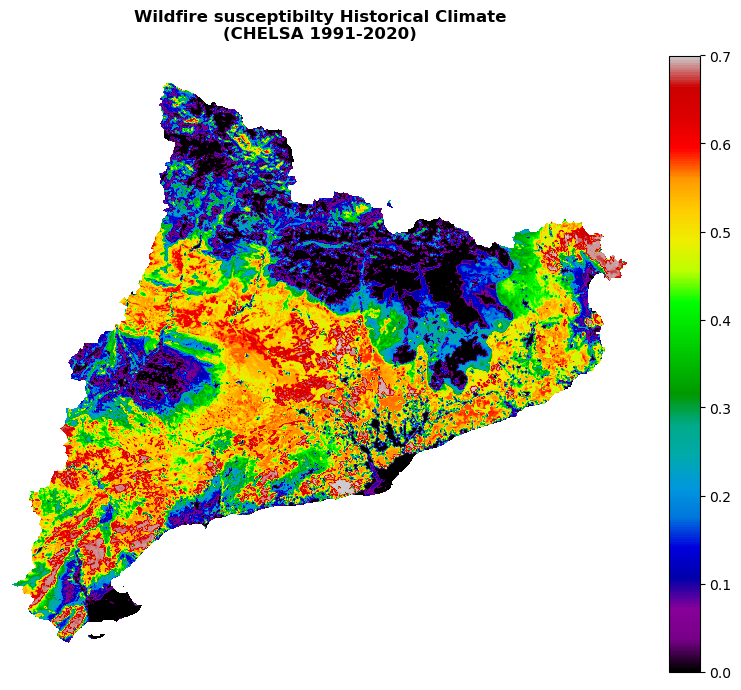

In [40]:
with rasterio.open(suscep_path_hist) as src:
    band = src.read(1)
    band = postprocess_susceptibility(band)
    shared_funcs.plot_raster_V2(
        band,
        ref,
        cmap='nipy_spectral',
        plot_kwargs={"vmin": 0, "vmax": 0.7},
        dpi=100,
        title=f"Wildfire susceptibilty Historical Climate\n(CHELSA {hist_period})"
    )

## Future climate data

### Future scenario and period selection

Choose:

1.  A representative concentration pathway scenario (`future_scenario`).

    - `rcp45`: RCP 4.5
    - `rcp85`: RCP 8.5

2.  A time period to run the machine learning model for (`future_period`).

    - `2021-2040`
    - `2041-2060`
    - `2061-2080`

3.  A climate model data source (`climate_model`).

    - `CSC-REMO2009`
    - `HIRHAM5`
    - `RACMO22E`
    - `RCA4`

:::{tip}
You can return to this point of the workflow and rerun the following cells for different combinations of RCP scenario and time period without having to train the machine learning model again (as long as you don't restart the Jupyter kernel).
:::

In [41]:
future_scenario = "rcp45"
future_period = "2041-2060"
climate_model = "CSC-REMO2009"

In [42]:
# Create a unique identifier from the selected combination for filenames
future_config_id = f"{future_scenario}_{climate_model}_{future_period}"

# Output path for raster files clipped to area of interest
clim_path_future = clim_path / "CHELSA_Future" / future_config_id

### Climate model data for chosen configuration

Download future CHELSA data and clip to area of interest.

In [43]:
# Climate data for future configuration
CHELSA_urls_future = [
    f"https://os.zhdk.cloud.switch.ch/chelsav2/EUR11/{future_scenario}/{climate_model}/{future_period}/bio/CHELSA_CSC-REMO2009_{future_scenario}_{var_name}_{future_period}_V.1.0.nc"
    for var_name in var_names
]

Reuse the `download_data` and `get_clipped_raster` functions defined above for the historical data.

In [44]:
for url in tqdm(CHELSA_urls_future):
    CHELSA_file = download_data(url, CHELSA_path_future / future_config_id)
    if CHELSA_file is not None:
        get_clipped_raster(CHELSA_file, clim_path_future)
        os.remove(CHELSA_file)

100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


### Resample and reproject

Resample and reproject the CHELSA data to the same resolution and CRS as the DEM data.
Reuse the `resample_clip_tif` function defined above for the historical data.

In [45]:
resample_clip_tif(
    clim_path_future.glob("CHELSA_*_V.1.0.tif"),
    left, bottom, right, top,
    ref_shape=ref.shape,
    remove_original=False
)

100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


### Run the model on future data

To project the model in the future, we need to repeat the same steps as above, but with the future climate data.
The DEM will be the same, and vegetation will be the same (in that case, it is a simplification, but it is ok for now).

In [46]:
Y_raster_future = run_model(model, clim_path_future, future_period)

processing vegetation density: 100%|██████████| 18/18 [00:12<00:00,  1.50it/s]
processing columns: 35it [00:02, 16.67it/s]
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.2s


Write the susceptibilty for the future climate:

In [47]:
suscep_path_future = suscep_path / f"suscep_{future_config_id}.tif"

shared_funcs.save_raster_as(Y_raster_future, suscep_path_future, dem_path_clip)

### Visualizing the future susceptibility

[0.         0.08000056 0.0800012  ... 0.7392137  0.73922765 0.7403546 ]
0.24120572


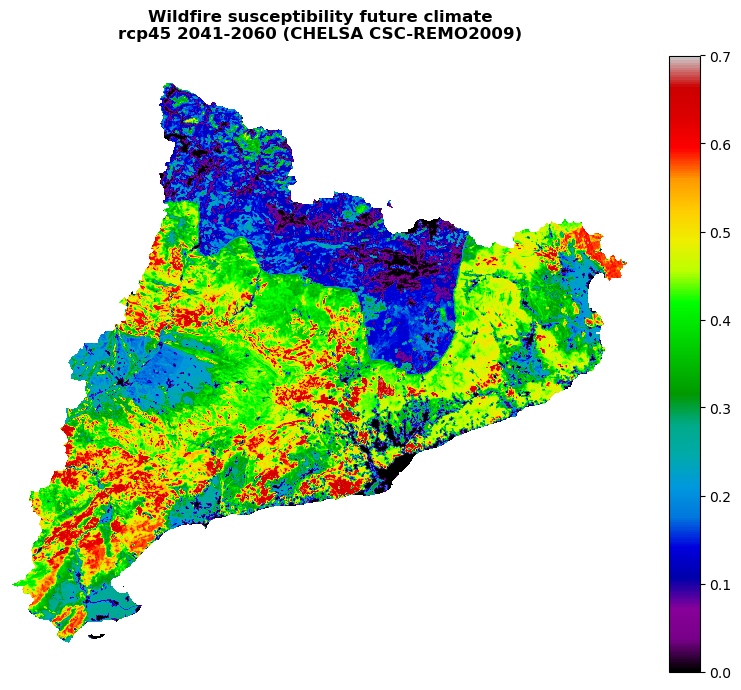

In [48]:
with rasterio.open(suscep_path_future) as src:
    band = src.read(1)
    band = postprocess_susceptibility(band)
    fig, ax = shared_funcs.plot_raster_V2(
        band,
        ref,
        cmap='nipy_spectral',
        plot_kwargs={"vmin": 0, "vmax": 0.7},
        title=(
            "Wildfire susceptibility future climate\n"
            f"{future_scenario} {future_period} (CHELSA {climate_model})"
        ),
        dpi=100
    )

## Hazard

Functions to define the hazard have been imported from `shared_funcs.py`.

Create the intensity matrix by converting the CLC raster:

In [49]:
my_clc_raster = shared_funcs.MyRaster(clc_path_clip_nb, "clc")

converter = pd.read_excel("./CORINE_to_FuelType.xlsx")
converter_dict = dict(zip(converter.veg.values, converter.aggr.values))

# I obtain the array of the fuel types converting the corine land cover raster
converted_band = shared_funcs.corine_to_fuel_type(my_clc_raster.data.data, converter_dict)

# dtype of the converted band
print('data type is: ', converted_band.dtype)
print('values of original map(here corine) are:','\n', np.unique(converter_dict.keys()))
print('Values of fuel map are:','\n', converter_dict.values())

data type is:  int64
values of original map(here corine) are: 
 [dict_keys([111, 112, 121, 122, 123, 124, 131, 132, 133, 141, 142, 211, 212, 213, 221, 222, 223, 224, 231, 241, 242, 243, 244, 311, 312, 313, 321, 322, 323, 324, 331, 332, 333, 334, 335, 411, 412, 421, 422, 423, 511, 512, 521, 522, 523, 999])]
Values of fuel map are: 
 dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 4, 4, 1, 3, 3, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


Obtain the hazard map for present climate crossing the susceptibility map with the intensity map:

In [50]:
hazard_path_hist = hazard_path / f"hazard_HIST_{hist_period}.tif"
hazard_path_future = hazard_path / f"hazard_{future_config_id}.tif"

In [51]:
# compute quantiles for Y_raster
quantiles = np.quantile(Y_raster[Y_raster>=0.0], [0.5, 0.75 ])
print('quantiles are: ', quantiles)

# compute discrete susc array
susc_arr = shared_funcs.susc_classes(Y_raster, quantiles) + 1 # >>>>>>>>>> I add 1 to avoid 0 values
print("Now I have just the susc classes", np.unique(susc_arr))

matrix_values = np.array([[1, 2, 3, 4],
                          [2, 3, 4, 5],
                          [3, 3, 5, 6]])

# Compute discrete hazard
hazard_arr = shared_funcs.contigency_matrix_on_array(susc_arr, converted_band, matrix_values, 0 ,-1)

# Future
Y_raster_future = shared_funcs.MyRaster(suscep_path_future, "susc_202140").data
# Compute susceptibility discrete array for future
susc_arr_future = shared_funcs.susc_classes(Y_raster_future, quantiles) + 1 # I add 1 to avoid 0 values
# Compute hazard discrete array for future
hazard_arr_future = shared_funcs.contigency_matrix_on_array(susc_arr_future, converted_band, matrix_values, 0, -1)

# Save the hazard arrays to file (raster)
shared_funcs.save_raster_as_h(hazard_arr, hazard_path_hist, clc_path_clip_nb)
shared_funcs.save_raster_as_h(hazard_arr_future, hazard_path_future, clc_path_clip_nb)

quantiles are:  [0.00828214 0.30701373]
Now I have just the susc classes [1 2 3]


Visualize the future and historical hazard classes:

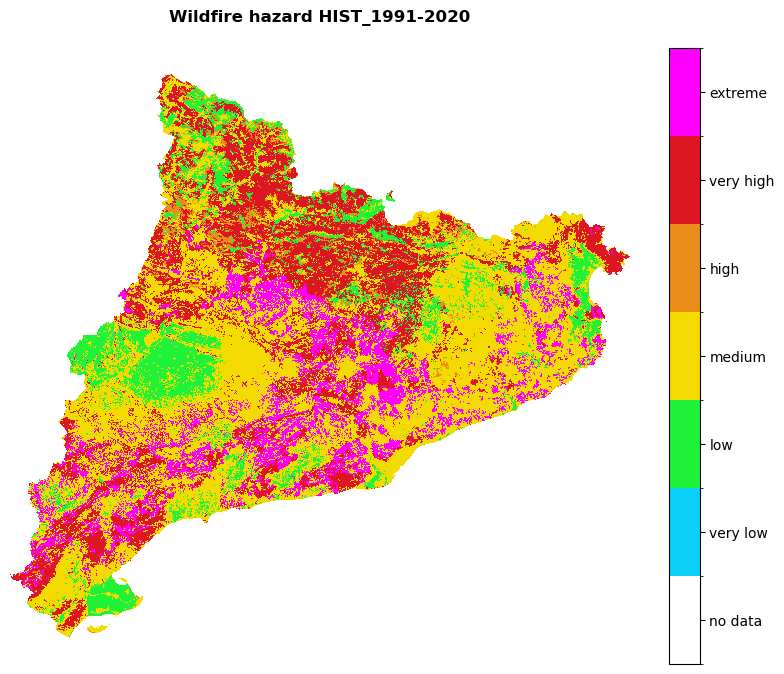

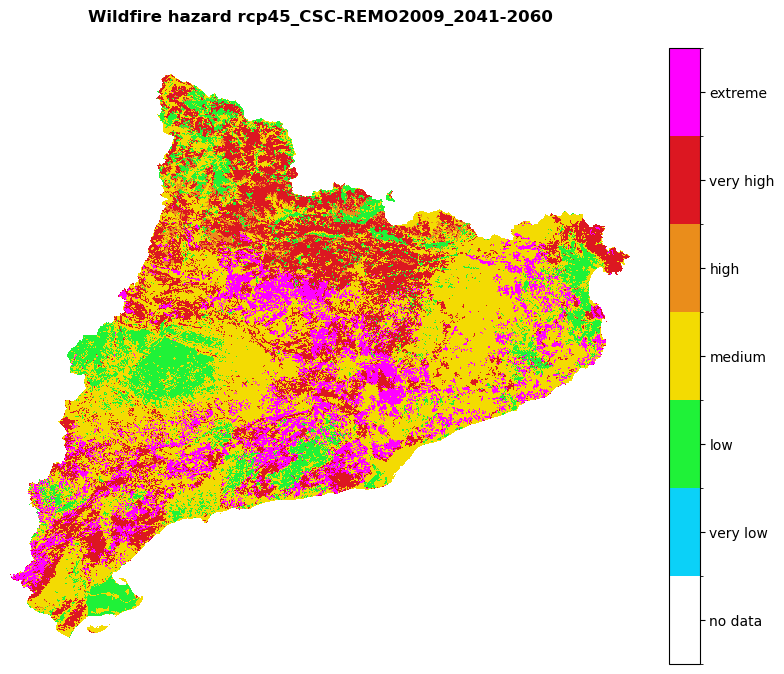

In [52]:
# Hazard cmap
values = [0, 0.9, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1]
colors_ = ['#00000000', '#0bd1f8', '#1ff238', '#f3db02', '#ea8d1b', '#dc1721', '#ff00ff']

# Create colormap
cmap = mcolors.ListedColormap(colors_, N=len(values))
#norm = mcolors.BoundaryNorm(values, len(values))

region_borders.to_crs(epsg=3035, inplace=True)

# Loop over hazard paths and plot
for hazard_path in [hazard_path_hist, hazard_path_future]:
    haz_arr = rasterio.open(hazard_path).read(1)
    name = os.path.basename(hazard_path).split('hazard_')[-1].split('.tif')[0]
    shared_funcs.plot_raster_V2(
        haz_arr,
        ref,
        array_classes=values,
        classes_colors=colors_,
        classes_names=['no data', 'very low', 'low', 'medium', 'high', 'very high', 'extreme'],
        title=f'Wildfire hazard {name}',
        dpi=100
    )

## Contributors

- Andrea Trucchia (Andrea.trucchia@cimafoundation.org)
- Farzad Ghasemiazma (Farzad.ghasemiazma@cimafoundation.org)
- Giorgio Meschi (Giorgio.meschi@cimafoundation.org)


## References

- Tonini, M.; D’Andrea, M.; Biondi, G.; Degli Esposti, S.; Trucchia, A.; Fiorucci, P. (2020): A Machine Learning-Based Approach for Wildfire Susceptibility Mapping. The Case Study of the Liguria Region in Italy. *Geosciences* 2020, 10, 105. DOI: [10.3390/geosciences10030105](https://doi.org/10.3390/geosciences10030105)

- Trucchia, A.; Meschi, G.; Fiorucci, P.; Gollini, A.; Negro, D. (2022): Defining Wildfire Susceptibility Maps in Italy for Understanding Seasonal Wildfire Regimes at the National Level. *Fire* 2022, 5, 30. DOI: [10.1071/WF22138](https://doi.org/10.3390/fire5010030)

- Trucchia, A.; Meschi, G.; Fiorucci, P.; Provenzale, A.; Tonini, M.; Pernice, U. (2023): Wildfire hazard mapping in the eastern Mediterranean landscape. *International Journal of Wildland Fire* 2023, 32, 417-434. DOI: [10.1071/WF22138](https://doi.org/10.1071/WF22138)

- Chakraborty Debojyoti, Dobor Laura, Zolles Anita, Hlásny Tomáš, & Schueler Silvio. (2020). High-resolution gridded climate data for Europe based on bias-corrected EURO-CORDEX: the ECLIPS-2.0 dataset. Zenodo. [https://doi.org/10.5281/zenodo.3952159](https://doi.org/10.5281/zenodo.3952159)

- Karger, D.N., Conrad, O., Böhner, J., Kawohl, T., Kreft, H., Soria-Auza, R.W., Zimmermann, N.E., Linder, P., Kessler, M. (2017): Climatologies at high resolution for the Earth land surface areas. Scientific Data. 4 170122. DOI: [10.1038/sdata.2017.122](https://doi.org/10.1038/sdata.2017.122)

- Karger, D.N., Dabaghchian, B., Lange, S., Thuiller, W., Zimmermann, N.E., Graham, C.H. (2020): High resolution climate data for Europe. EnviDat. DOI: [10.16904/envidat.150](http://dx.doi.org/doi:10.16904/envidat.150)